# **Project Overview:**

## Objective: 
Develop a classification model to predict the potability of water based on its physicochemical properties. The goal is to determine whether a given sample of water is safe for consumption (potable) or not, using various features like pH level, hardness, solids, and other water quality metrics.

## Data Description,
The water_potability.csv file contains water quality measurements for 3,276 different water bodies. It includes 9 feature variables, with a target variable called potability (1 indicating the water is potable and 0 indicating it is not).

Source:  [https://www.kaggle.com/datasets/adityakadiwal/water-potability/data](https://www.kaggle.com/datasets/adityakadiwal/water-potability/data)

## Import Libraries

In [2]:
# EDA
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Scalars and Model selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score, KFold,StratifiedKFold, cross_validate, RepeatedKFold, cross_val_predict
from sklearn.impute import KNNImputer # preprocessing for missing value
from imblearn.over_sampling import SMOTE, ADASYN # preprocessing for oversampling
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import AllKNN



from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler # preprocessing for Standardization
from sklearn.decomposition import PCA # preprocessing for dimensional reduction

 #Classifiers
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier



from sklearn.pipeline import make_pipeline # pipeline
from imblearn.pipeline import Pipeline

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, confusion_matrix, classification_report, RocCurveDisplay, make_scorer, f1_score



## Load Dataset

In [3]:
data_water = pd.read_csv("../data/water_quality_prediction_data/water_potability.csv", index_col=None)
data_ori = data_water.copy()

## Explanatory Data Analysis (EDA)

In [4]:
# Quck overview of the data
data_water.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [5]:
data_water.describe().T.style.background_gradient(subset=['mean','std','50%','count'], cmap='PuBu')

,count,mean,std,min,25%,50%,75%,max
ph,2785.000000,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.000000,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.000000,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.000000,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.000000,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.000000,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.000000,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.000000,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.000000,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.000000,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


### Class Distribution

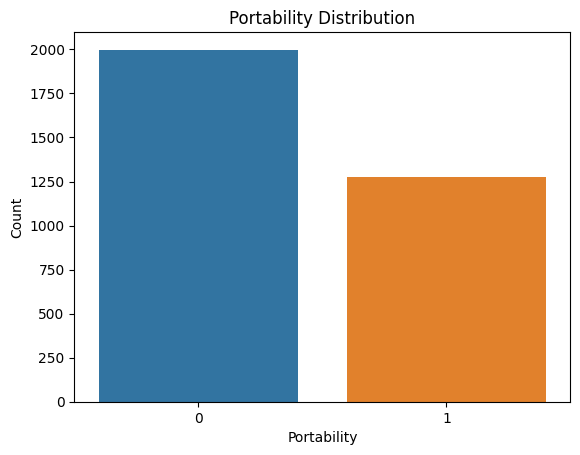

Potability
0    1998
1    1278
Name: count, dtype: int64

In [6]:
sns.countplot(x='Potability', data=data_water)
plt.title('Portability Distribution')
plt.xlabel('Portability')
plt.ylabel('Count')
plt.show()

data_water["Potability"].value_counts()


## Data Preprocessing
### Handling Missing Values and Duplicate Rows

In [7]:
# Identify a missing data
data_water.isnull().sum()/len(data_water)

ph                 0.149878
Hardness           0.000000
Solids             0.000000
Chloramines        0.000000
Sulfate            0.238400
Conductivity       0.000000
Organic_carbon     0.000000
Trihalomethanes    0.049451
Turbidity          0.000000
Potability         0.000000
dtype: float64

In [8]:
# Validate for duplicate data entries
data_water.duplicated().sum()

0

In [9]:
target = 'Potability'
missing = 'Sulfate'

X = data_water.drop(columns=[target])
y = data_water[target]

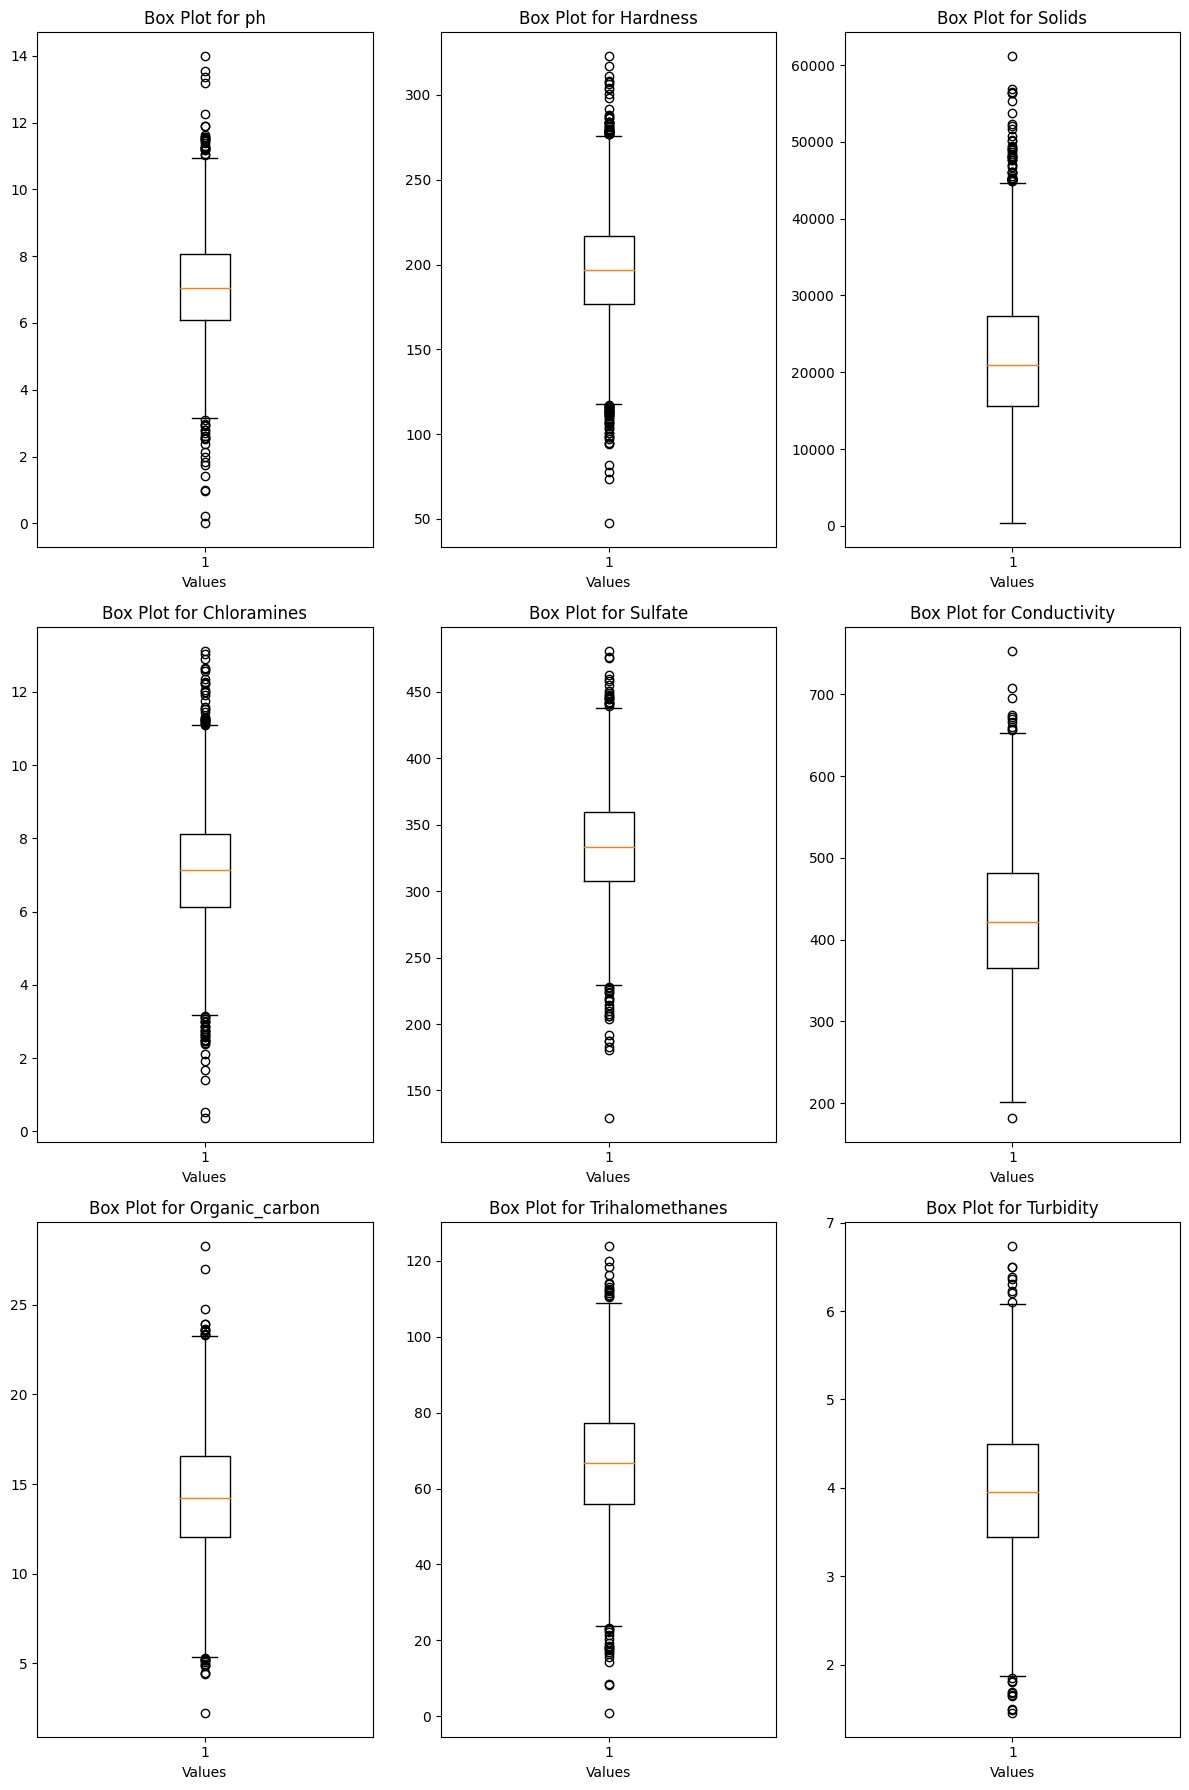

In [10]:
# Set the figure size for the subplots
plt.figure(figsize=(12,18))

# Iterate through the columns and create individual box plots
for i, column in enumerate(X.columns, 1):
    plt.subplot(3, len(X.columns) //3, i)  # Create a subplot for each column
    plt.boxplot(X[column].dropna())
    plt.title(f'Box Plot for {column}')
    plt.xlabel('Values')
    plt.ylabel('')
    

plt.tight_layout()  # Adjust subplot spacing

plt.show()

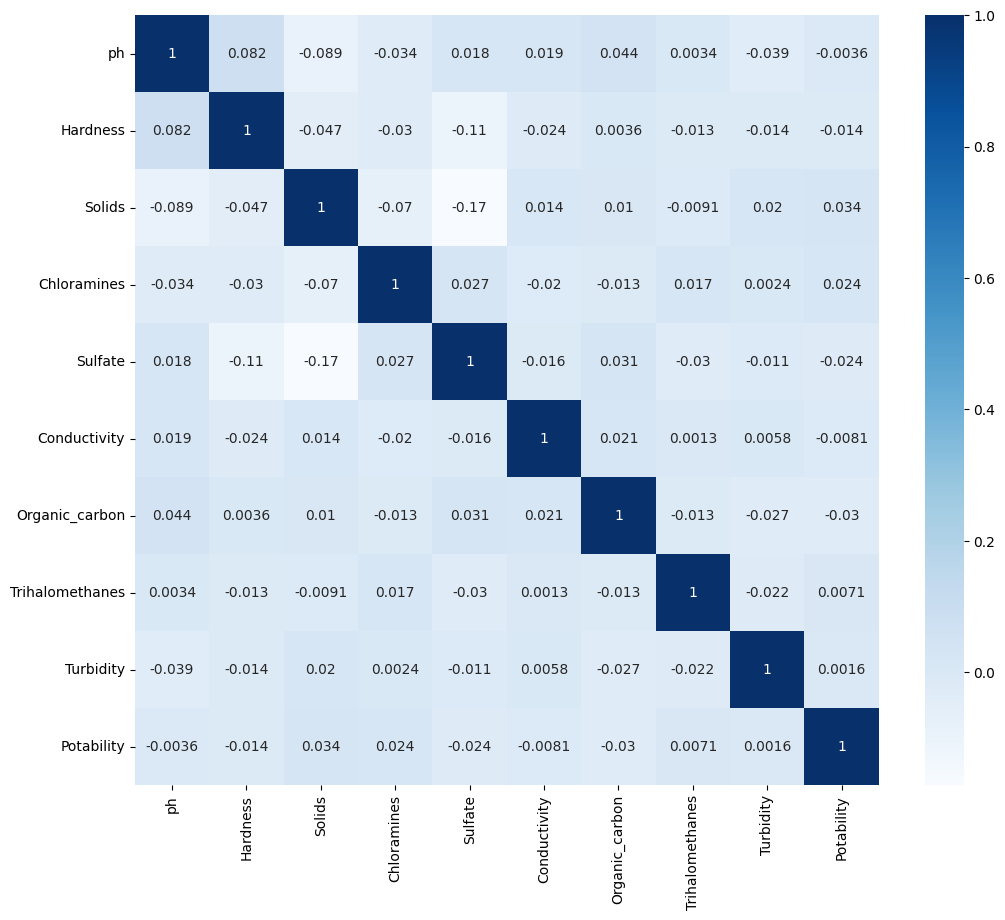

In [30]:
plt.figure(figsize=(12,10))
cor = data_water.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Blues)
plt.show()


In our exploratory data analysis, we identified several important aspects for the upcoming analysis:

small correlation between variables: the dimesnion reduction would be not recommend for the preprocessing steps

Target Imbalance: The target variable shows a pronounced imbalance with a 1998:1278 ratio, where the negative class dominates.

- StratifiedKFold for Cross-Validation: 
Given this class imbalance, we’ll use StratifiedKFold, a variant of k-fold cross-validation. This approach ensures each fold maintains the same class distribution as the original dataset, supporting a more balanced evaluation.

- F1 Score and Recall as Key Metrics:
Given the imbalanced nature of the data, the F1 score is prioritized over accuracy as the primary evaluation metric. In the context of water quality, minimizing false negatives is critical to prevent people from consuming unsafe water. Therefore, recall will be closely monitored to ensure the accurate identification of positive cases, reducing the risk of undetected contamination.


In [12]:
def build_pipeline(scalar = True, imputer = True, smote = True):
    """
    A function that takes a model as an argument and returns the full pipeline.
    """
    steps = []
    if scalar:
        steps.append(('scaler', RobustScaler()))
    if imputer:
        steps.append(('imputer', KNNImputer(missing_values=np.nan)))
    if smote:
        steps.append(('smote', SMOTE()))

    def pipeline_with_model(model):
        """Returns a pipeline with the specified model."""
        return Pipeline(steps + [('model', model)])
    
    return pipeline_with_model

In [35]:

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33)

classifiers = [
    ('K Neighbors Classifier', KNeighborsClassifier(n_neighbors =5)),
    ('Decision Tree Classifier', DecisionTreeClassifier(random_state=33)),
    ('Random Forest Classifier', RandomForestClassifier(random_state=33)),
    ('SVC',SVC(random_state =33)),
    ('Gaussian NB',GaussianNB()),
    ('Logistic Regression', LogisticRegression(penalty= 'l2', solver='liblinear', random_state=33)),
]

scoring = {
    'accuracy': 'roc_auc',
    'f1' : 'f1_weighted',
    'recall': 'recall',
}

skf = StratifiedKFold(n_splits=10, shuffle= True,  random_state=33)


In [42]:
class bar_chart:

    def __init__(self, addin_title=""):
        self.addin_title = addin_title

    def draw_chart(self,input):

        df_bar = pd.DataFrame(input, columns=['Model', 'Accuracy', 'Recall', 'f1'])
        df_bar.sort_values(by='f1', inplace=True, ascending=False)

        # Melt the DataFrame for Seaborn
        df_melted = df_bar.melt(id_vars='Model', var_name='Metric', value_name='Value')


        plt.figure(figsize=(14, 6))
        sns.barplot(data=df_melted, x='Model', y='Value', hue='Metric', palette='mako')
            
        # Customize the plot
        plt.title(f"Grouped Bar chart with predicted model ({self.addin_title})")
        plt.xlabel('Model')
        plt.ylabel('Percentage rate')
        plt.legend(title='Metric')

        # Show plot
        plt.show()


In [37]:

def preprocessing_viz(classifiers, scoring, pipeline_model):

    temp_bar = []
    for name, model in classifiers:

        cv_results = cross_validate(pipeline_model(model), X, y, cv=skf, scoring=scoring)
        temp_bar.append((name,cv_results['test_accuracy'].mean(), cv_results['test_recall'].mean(), cv_results['test_f1'].mean()))

    return temp_bar


In [38]:
data_score = preprocessing_viz(classifiers, scoring, build_pipeline())
data_no_smote = preprocessing_viz(classifiers, scoring, build_pipeline(smote=False))

One approach I explored in this project was using an oversampling method, such as SMOTE, to balance the class distribution of the target variable. An imbalanced target variable can introduce biases in the model. Initially, after applying SMOTE, the model's accuracy slightly dropped compared to the original version. However, I shifted my focus to recall and observed that the initial model without oversampling had a very low recall, resulting in a poor true positive rate.

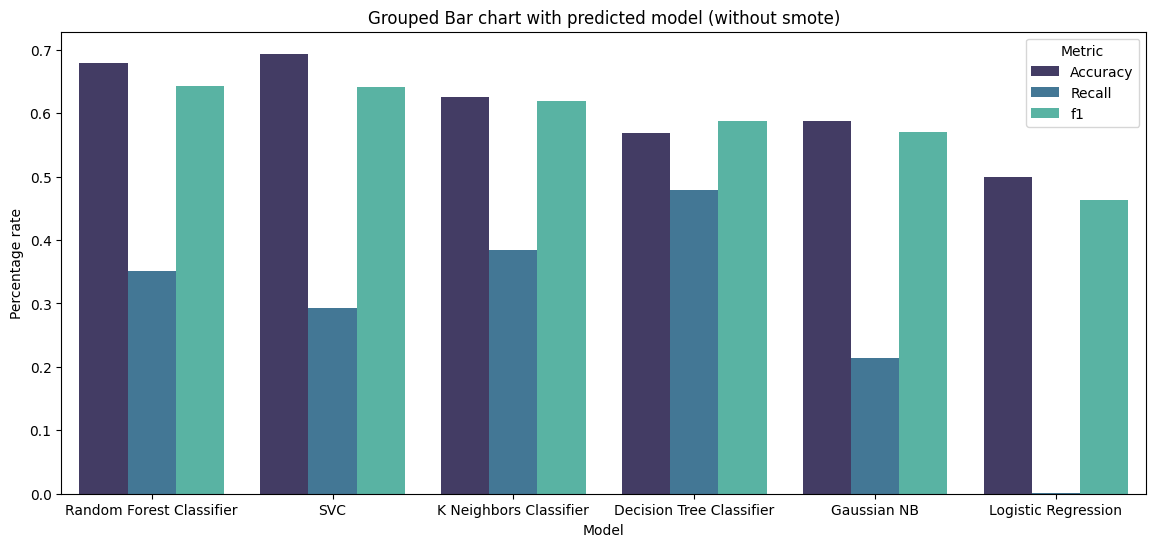

In [43]:
a = bar_chart("without smote")
a.draw_chart(data_no_smote)

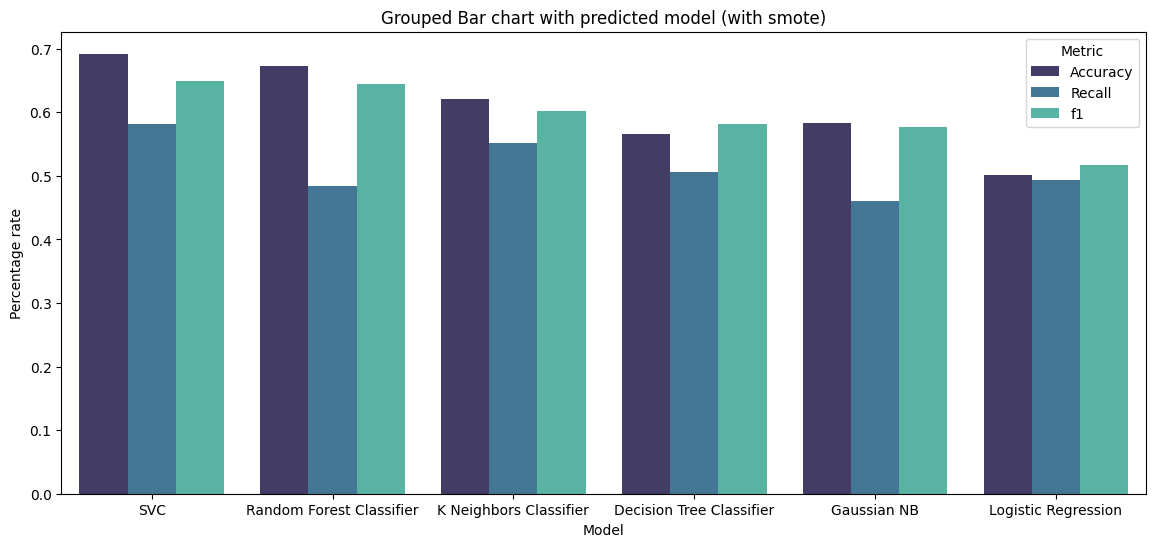

In [44]:
b = bar_chart("with smote")
b.draw_chart(data_score)

##  Reflections: 

This is my first time implementing oversampling techniques in the analysis. Unfortunately, the overall accuracy of the oversampled data was significantly lower than that of the original scaled data. However, as you can see in the graph, recall value was significant lower than lower when implementing the 


Furthermore, I selected three classifiers with the highest cross-validation scores for in-depth analysis. These are the Support Vector Classifier (SVC), Random Forest Classifier, and KNeighbors Classifier, with cross-validation f-1 weighted scores of 64.06%, 63.67%, and 58.92% respectively.

In [19]:
top_classifiers = [
    ('K Neighbors Classifier', KNeighborsClassifier(n_neighbors =5)),
    ('Random Forest Classifier', RandomForestClassifier(random_state=33)),
    ('SVC',SVC(random_state =33)),
]


In [ ]:

# f1 score weighted favors toward recall
ftwo_scorer = make_scorer(fbeta_score, beta=0.5)

# Model
pipe = build_pipeline(SVC(random_state =33))
pipe.fit(X_train, y_train)
print()
svc_probs = pl_svc.predict_proba(X_test)
svc_probs = svc_probs[:,1]

AttributeError: predict_proba is not available when probability=False

In [ ]:
# Initialize StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=33)

# Model
model = RandomForestClassifier()

# Arrays to store results
y_true = []  # True labels
y_pred_prob = []  # Predicted probabilities for the positive class

for train_idx, test_idx in skf.split(X, y):
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    # Train the model
    model.fit(X_train, y_train)
    
    # Predict probabilities
    probas = model.predict_proba(X_test)[:, 1]  # Positive class probabilities
    
    # Store results
    y_true.extend(y_test)
    y_pred_prob.extend(probas)

# Evaluate the performance
roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f"Cross-validated ROC-AUC: {roc_auc:.4f}")



TypeError: Singleton array array(Ellipsis, dtype=object) cannot be considered a valid collection.

              precision    recall  f1-score   support

           0       0.72      0.68      0.70      1998
           1       0.54      0.58      0.56      1278

    accuracy                           0.64      3276
   macro avg       0.63      0.63      0.63      3276
weighted avg       0.65      0.64      0.64      3276



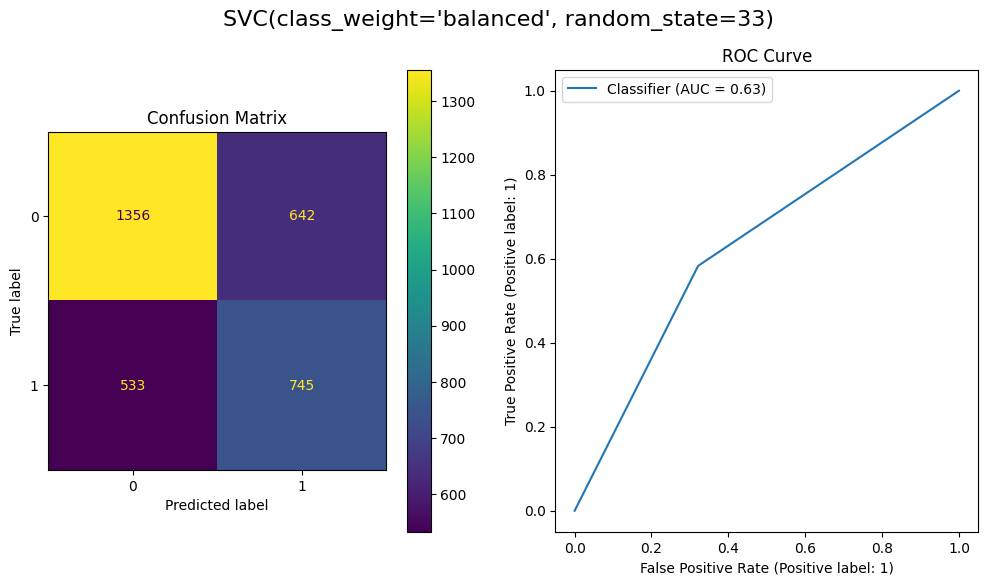



              precision    recall  f1-score   support

           0       0.70      0.75      0.72      1998
           1       0.56      0.48      0.52      1278

    accuracy                           0.65      3276
   macro avg       0.63      0.62      0.62      3276
weighted avg       0.64      0.65      0.64      3276



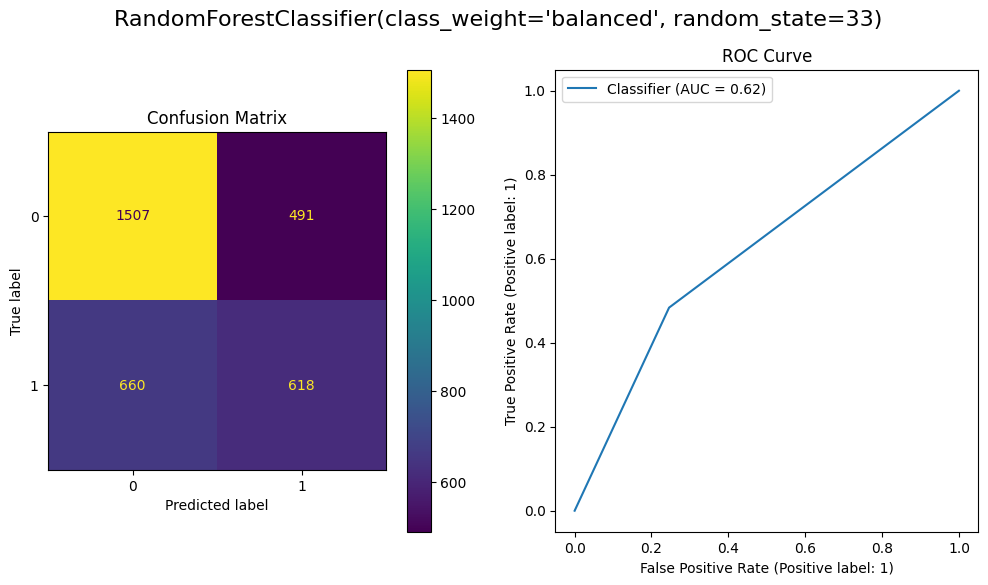



              precision    recall  f1-score   support

           0       0.71      0.64      0.67      1998
           1       0.51      0.59      0.55      1278

    accuracy                           0.62      3276
   macro avg       0.61      0.62      0.61      3276
weighted avg       0.63      0.62      0.63      3276



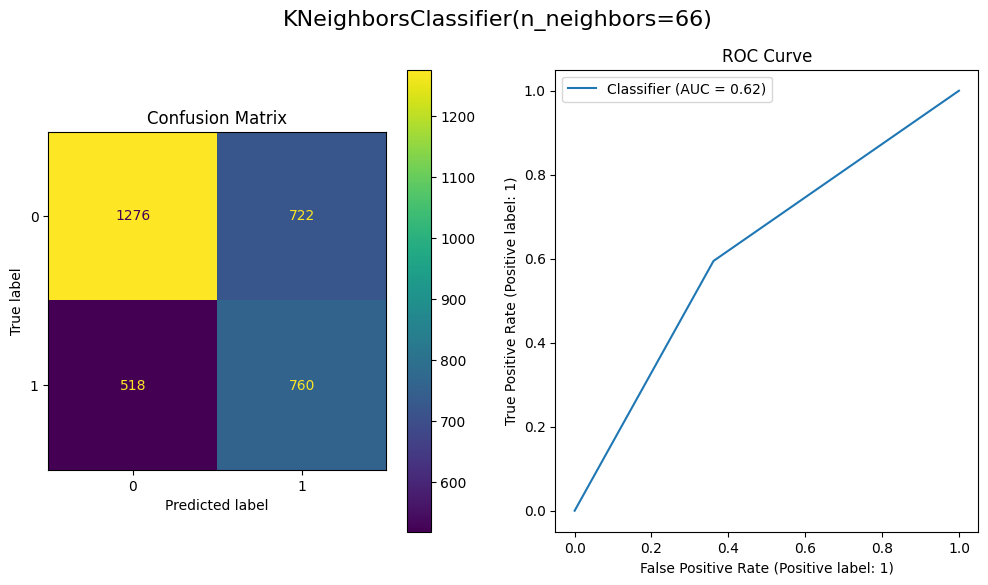

In [29]:

# Define a custom scoring dictionary if you want to measure multiple metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score),
    'f1': make_scorer(f1_score)  # You can add more metrics as needed
}

top_classifiers = [
    SVC(random_state=33, class_weight='balanced'),
    RandomForestClassifier(random_state=33, class_weight='balanced'),
    KNeighborsClassifier(n_neighbors=66)
]


for classifier in top_classifiers:
    pipe = Pipeline([
        ('scaler', RobustScaler()),
        ('imputer', KNNImputer(missing_values=np.nan)),
        ('smote', SMOTE()), 
        ('classifier', classifier)
    ])
    # Lists to hold true and predicted values
    y_true_all = []
    y_pred_all = []

    # Perform cross-validation
    for train_idx, test_idx in skf.split(X, y):
        pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
        y_pred = pipe.predict(X.iloc[test_idx])
        
        # Collect true and predicted values
        y_true_all.extend(y.iloc[test_idx])
        y_pred_all.extend(y_pred)

    # Generate the classification report
    print(classification_report(y_true_all, y_pred_all))  

    # Plotting Confusion Matrix and ROC
    fig, [ax_con, ax_roc] = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(str(classifier), fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_true_all, y_pred_all, labels=pipe.classes_)
    disp_C = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp_C.plot(ax=ax_con)
    ax_con.set_title('Confusion Matrix')

    # ROC Curve
    disp_R = RocCurveDisplay.from_predictions(y_true_all, y_pred_all, drop_intermediate= False, ax=ax_roc)
    ax_roc.set_title('ROC Curve')

    plt.legend()    
    plt.show()
    print('\n')

In [36]:


    # Display scores on test set
    print(f'Test Accuracy for {classifier}: {accuracy_score(y_test, y_pred):.4f}')
    print(f'Test Precision for {classifier}: {precision_score(y_test, y_pred):.4f}')
    print(classification_report(y_test, y_pred))
    
    # Plotting Confusion Matrix and ROC
    fig, [ax_con, ax_roc] = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(str(classifier), fontsize=16)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=pipe.classes_)
    disp_C = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipe.classes_)
    disp_C.plot(ax=ax_con)
    ax_con.set_title('Confusion Matrix')

    # ROC Curve
    disp_R = RocCurveDisplay.from_estimator(pipe, X_test, y_test, ax=ax_roc)
    ax_roc.set_title('ROC Curve')

    plt.legend()    
    plt.show()
    print('\n')


NameError: name 'classifier' is not defined

## conclusion:  
While Gaussian NB() appears to be the most accurate classification model for this data, the overall performance is still lacking. Further improvement is necessary.

- Conducted a quick Exploratory Data Analysis (EDA) for initial observations of dataset characteristics.
- Utilized an imputer and oversampling method to fill missing data, ensuring a comprehensive dataset.
- Applied a scaler for improved accuracy in data representation.
- These steps, including thorough data exploration, effective handling of missing values, and optimization for accurate predictions, collectively contribute to a robust foundation for the classification model.


